In [75]:
import os
import re
import shutil
import string
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.strings import lower, regex_replace
from tensorflow.keras.preprocessing import text_dataset_from_directory

from keras.optimizers import Adam
from keras import Sequential, preprocessing
from keras.losses import BinaryCrossentropy
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers.experimental.preprocessing import TextVectorization
from keras.layers import Dense, GlobalAveragePooling1D, Dropout, Embedding, Activation

In [76]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file(
  "aclImdb_v1", 
  url,
  untar=True, cache_dir='.',
  cache_subdir=''
)

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [77]:
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

print(train_dir, test_dir)

./aclImdb/train ./aclImdb/test


In [78]:
# Sample file
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [79]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [80]:
batch_size = 32
seed = 42

raw_train_ds = text_dataset_from_directory(
  train_dir, 
  batch_size=batch_size, 
  validation_split=0.2, 
  subset='training', 
  seed=seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [81]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [82]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [83]:
raw_val_ds = text_dataset_from_directory(
  train_dir, 
  batch_size=batch_size, 
  validation_split=0.2, 
  subset='validation', 
  seed=seed
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [84]:
raw_test_ds = text_dataset_from_directory(
  test_dir, 
  batch_size=batch_size
)

Found 25000 files belonging to 2 classes.


In [85]:
def custom_standardization(input_data):
  lowercase = lower(input_data)
  stripped_html = regex_replace(lowercase, '<br />', ' ')
  return regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

In [86]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
  standardize=custom_standardization,
  max_tokens=max_features,
  output_mode='int',
  output_sequence_length=sequence_length
)

In [87]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [88]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [89]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

In [90]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


In [91]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [92]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [93]:
embedding_dim = 16

In [94]:
model = Sequential()
model.add(Embedding(max_features + 1, embedding_dim))
model.add(Dropout(0.5))

model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))

model.add(Dense(1))

opt = Adam(learning_rate=0.001)

earlystop = EarlyStopping(patience=5)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

model.compile(
  loss=BinaryCrossentropy(from_logits=True),
  optimizer=opt,
  metrics=['accuracy']
)

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
625/625 [==============================] - 10s 14ms/step - loss: 0.6869 - accuracy: 0.5052 - val_loss: 0.6434 - val_accuracy: 0.4956
Epoch 2/10
625/625 [==============================] - 4s 6ms/step - loss: 0.6178 - accuracy: 0.5549 - val_loss: 0.5490 - val_accuracy: 0.6496
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.5237 - accuracy: 0.7067 - val_loss: 0.4714 - val_accuracy: 0.7624
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.4517 - accuracy: 0.7863 - val_loss: 0.4180 - val_accuracy: 0.8062
Epoch 5/10
625/625 [==============================] - 3s 5ms/step - loss: 0.4024 - accuracy: 0.8210 - val_loss: 0.3826 - val_accuracy: 0.8278
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3645 - accuracy: 0.8483 - val_loss: 0.3583 - val_accuracy: 0.8390
Epoch 7/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3383 - accuracy: 0.8541 - val_loss: 0.3402 - val_accuracy: 0.8462
Epoc

In [95]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
dropout_16 (Dropout)         (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d_7 ( (None, 16)                0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [96]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 7s 9ms/step - loss: 0.3248 - accuracy: 0.8531
Loss:  0.3248298466205597
Accuracy:  0.8531200289726257


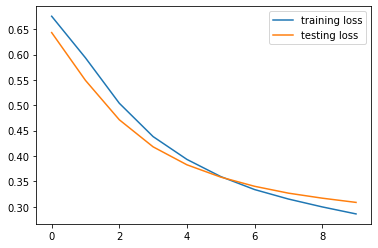

In [97]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='testing loss')
plt.legend();

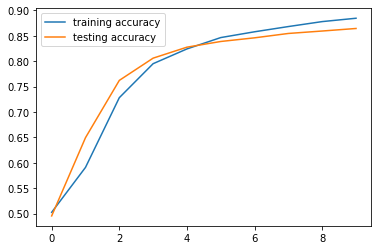

In [98]:
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='testing accuracy')
plt.legend();

In [99]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  Activation('sigmoid')
])

export_model.compile(
    loss=BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 9s 11ms/step - loss: 0.3248 - accuracy: 0.8681
0.8680800199508667


In [100]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

predictions = (export_model.predict(examples) > 0.5).astype("int32")
print(predictions)

[[1]
 [0]
 [0]]


In [104]:
export_model.save("model")

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


In [107]:
!zip -r model.zip model

updating: model/ (stored 0%)
  adding: model/variables/ (stored 0%)
  adding: model/variables/variables.index (deflated 60%)
  adding: model/variables/variables.data-00000-of-00001 (deflated 11%)
  adding: model/assets/ (stored 0%)
  adding: model/keras_metadata.pb (deflated 75%)
  adding: model/saved_model.pb (deflated 89%)
